In [1]:
## Time Division

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import math

# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)


## 퀀트함수 ## 절대경로 참조
import sys, os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))
from quant_functions import anal_funcs, data_funcs

## Func

In [ ]:
## 동일 가중 시분할 시뮬레이션
def get_INDI(df_ori, flow, terms = 120, seed = 0, fx= 1300):
    '''
    df: 종가데이터
    flow: 월납입액
    terms: 투자기간
    seed: 초기투자금
    fx: 달러원환율
    '''
    flow = flow*fx
    seed = seed*fx
    tickers = list(df_ori.columns)
    df_clean = df_ori.dropna()
    df_clean = df_clean.resample('M').last()
    dfs = [df_clean[i:i+terms] for i in range(len(df_clean)-terms+1)]
    _ls = []
    ## 역사적 시뮬레이션
    for df in dfs:
        for ticker in tickers:
            df[f"{ticker}_quant"] = (float(flow)/df[ticker]).apply(lambda x:math.floor(x))
            df[f"{ticker}_cost"] = df[ticker] * df[f"{ticker}_quant"]
            df[f"{ticker}_cquant"] = df[f"{ticker}_quant"].cumsum()
            df[f"{ticker}_cquant"] = df[f"{ticker}_cquant"] + math.floor(seed/df[ticker][0])
            df[ticker] = df[ticker] * df[f"{ticker}_cquant"]
        df = df[tickers]
        _ls.append(df.reset_index(drop=True))
    result = pd.concat(_ls, axis=1)
    
    ## 통계량 도출: 몬테카를로
    _stats = []
    for ticker in tickers:
        stat = pd.concat([result[ticker].mean(axis=1), result[ticker].min(axis=1), result[ticker].max(axis=1), result[ticker].std(axis=1)], axis=1)
        stat.columns = ['mean', 'min', 'max', 'std']
        
        stat['s2+'] = stat['mean'] + 2*stat['std']
        stat['s2-'] = stat['mean'] - 2*stat['std']
        stat['s3+'] = stat['mean'] + 3*stat['std']
        stat['s3-'] = stat['mean'] - 3*stat['std']
        
        _stats.append(stat.drop(columns='std'))
    
    return result[tickers], dict(zip(tickers, _stats))

## Proc

In [85]:
## 원천데이터 불러옴
## df_ori = get_merged_df('^IXIC', '^GSPC')
df_ori = data_funcs.get_merged_df('SPY', 'QQQ', 'IWM', 'VTI', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY', 'GLD', 'DBC', 'QLD', 'TQQQ')
## 무위험자산
df_ori['CASH'] = [(1+0.03)**(n/252) for n in range(len(df_ori))]

[*********************100%%**********************]  13 of 13 completed


In [121]:
# Calculate historical expected returns and volatility for each asset
expected_returns = df_ori.pct_change().mean() * 252
volatility = df_ori.pct_change().std() * np.sqrt(252)

# Create a DataFrame to store the results
summary_stats = pd.DataFrame({
    'Expected Return': expected_returns,
    'Volatility': volatility
})

summary_stats.round(4).sort_values('Expected Return', ascending=False)*100

,Expected Return,Volatility
Ticker,,
TQQQ,54.40,60.53
QLD,31.58,43.91
QQQ,13.32,27.21
SPY,11.78,18.63
IWM,10.91,24.03
VTI,10.80,19.20
GLD,9.95,17.54
VWO,9.17,26.72
VEA,5.56,21.92


In [104]:
df_indi, stats = get_INDI(df_ori[:], 0, int(12*5), 10000, 1)
## df_indi, stats = get_INDI(df_ori[:], 120*1250, int(12*15), 0)

In [105]:
X1, X2, X3 = 'QQQ', 'QLD', 'TQQQ'

data = pd.concat([stats[X1]['mean'], stats[X1]['s3-'], stats[X1]['s3+'],
                  stats[X2]['mean'], stats[X2]['s3-'], stats[X2]['s3+'],
                  stats[X3]['mean'], stats[X3]['s3-'], stats[X3]['s3+'],
                  stats['CASH']['mean']], axis=1)

data.columns = ['X1', 'X1_min', 'X1_max',
                'X2', 'X2_min', 'X2_max', 
                'X3', 'X3_min', 'X3_max',
                'rf']

data = (data/10000)

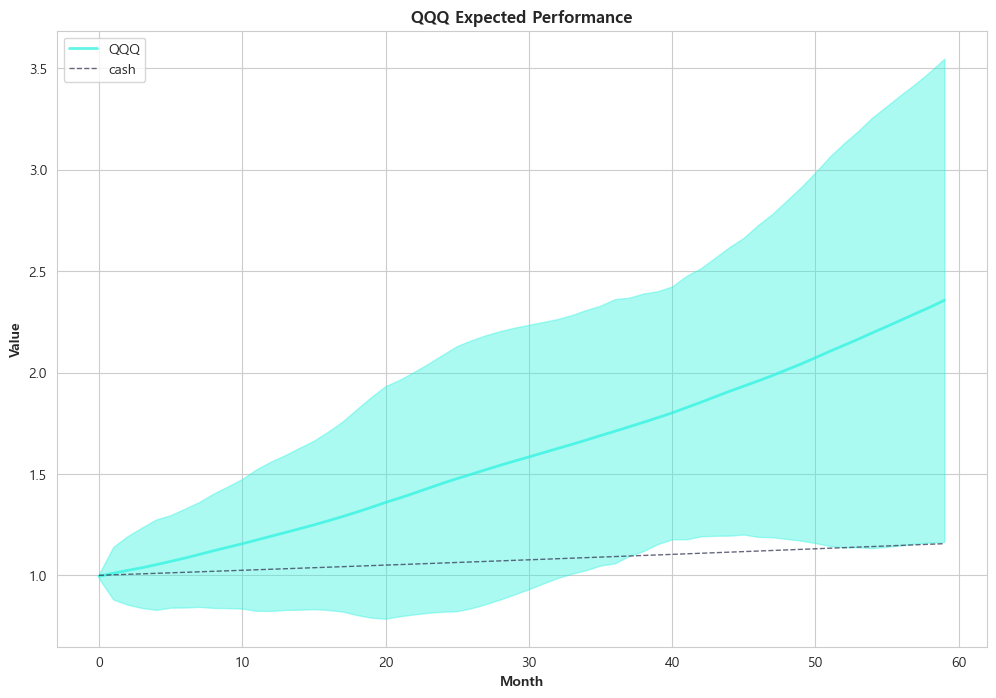

In [129]:
fig, ax = plt.subplots(figsize=(12, 8))
line1 = ax.plot(data.index, data['X1'],
        color="#2FF3E0", alpha=0.75, label=X1, linewidth=2)
fill1 = ax.fill_between(data.index, data['X1_min'], data['X1_max'], color = '#2FF3E0', alpha=0.4)

line_base = ax.plot(data.index, data['rf'],
        color="#333652", alpha=0.75, label="cash", linewidth=1, linestyle= '--')

plt.xlabel('Month', fontweight='bold')
plt.ylabel('Value', fontweight='bold')
plt.title('QQQ Expected Performance', fontweight='bold')
plt.legend(loc='upper left')

## plt.yscale('log')
plt.show()

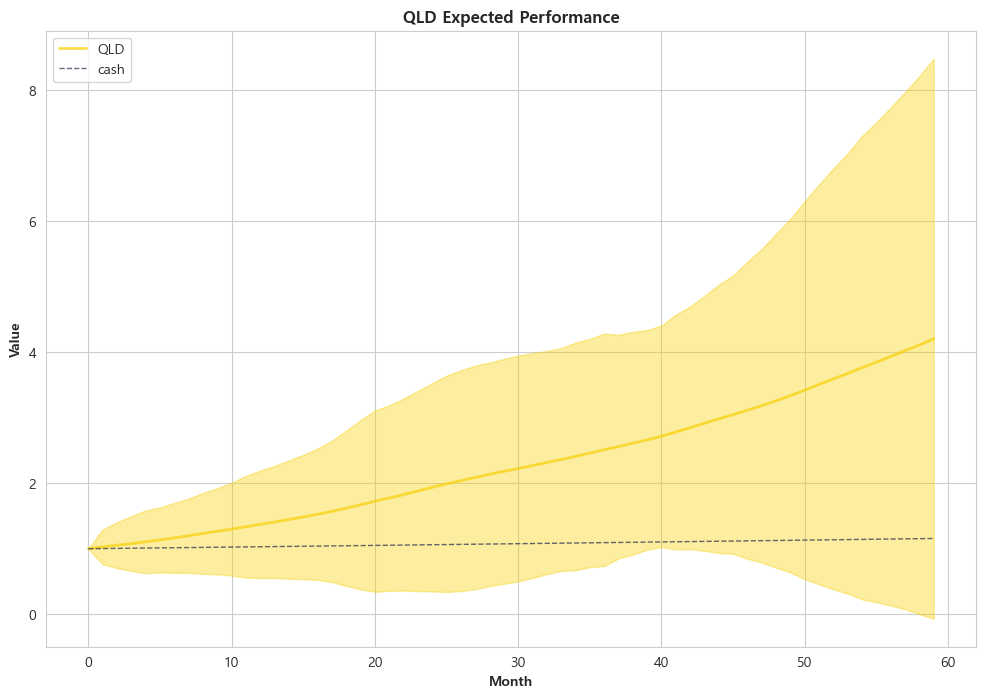

In [130]:
fig, ax = plt.subplots(figsize=(12, 8))
line2 = ax.plot(data.index, data['X2'],
        color="#F8D210", alpha=0.75, label=X2, linewidth=2)
fill2 = ax.fill_between(data.index, data['X2_min'], data['X2_max'], color = '#F8D210', alpha=0.4)

line_base = ax.plot(data.index, data['rf'],
        color="#333652", alpha=0.75, label="cash", linewidth=1, linestyle= '--')

plt.xlabel('Month', fontweight='bold')
plt.ylabel('Value', fontweight='bold')
plt.title('QLD Expected Performance', fontweight='bold')
plt.legend(loc='upper left')

## plt.yscale('log')
plt.show()

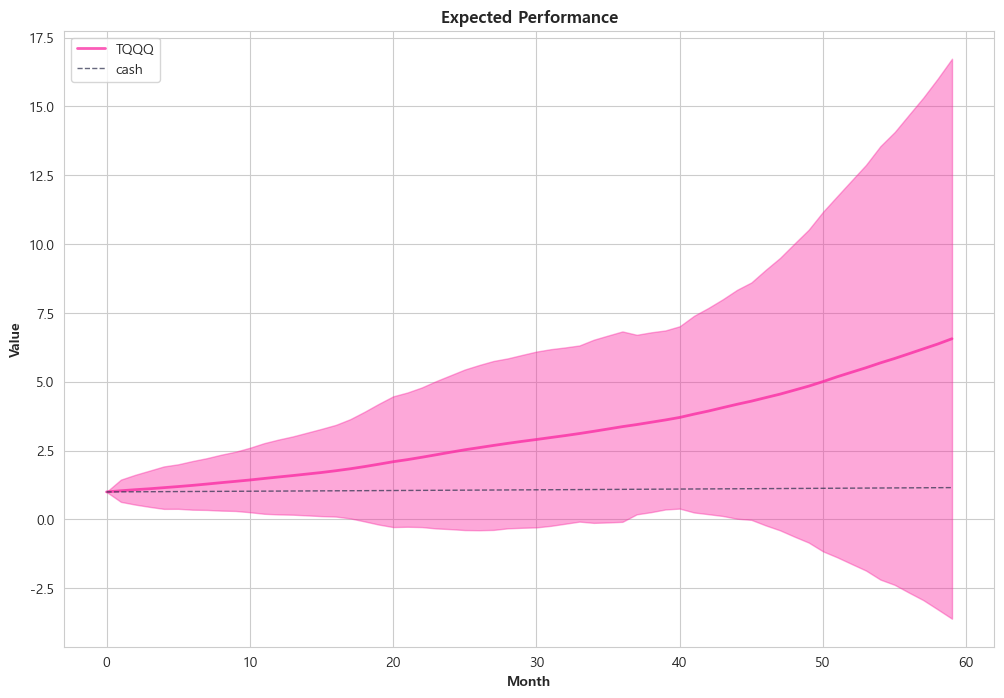

In [125]:
fig, ax = plt.subplots(figsize=(12, 8))
line3 = ax.plot(data.index, data['X3'],
        color="#FA26A0", alpha=0.75, label=X3, linewidth=2)
fill3 = ax.fill_between(data.index, data['X3_min'], data['X3_max'], color = '#FA26A0', alpha=0.4)

line_base = ax.plot(data.index, data['rf'],
        color="#333652", alpha=0.75, label="cash", linewidth=1, linestyle= '--')

plt.xlabel('Month', fontweight='bold')
plt.ylabel('Value', fontweight='bold')
plt.title('Expected Performance', fontweight='bold')
plt.legend(loc='upper left')

## plt.yscale('log')
plt.show()

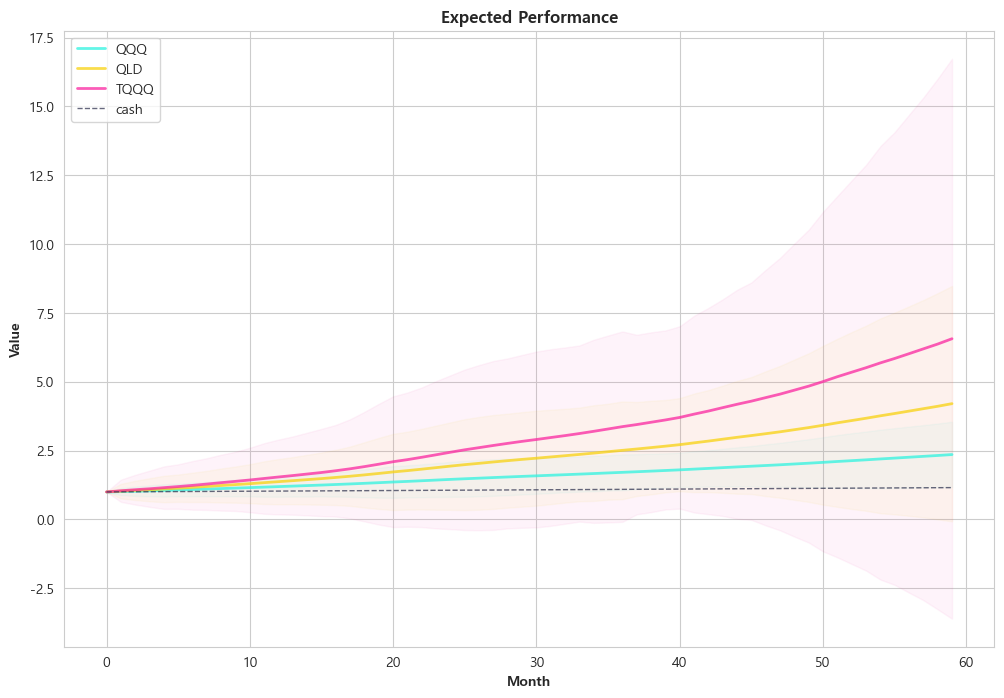

In [131]:
fig, ax = plt.subplots(figsize=(12, 8))
line1 = ax.plot(data.index, data['X1'],
        color="#2FF3E0", alpha=0.75, label=X1, linewidth=2)
fill1 = ax.fill_between(data.index, data['X1_min'], data['X1_max'], color = '#2FF3E0', alpha=0.05)

line2 = ax.plot(data.index, data['X2'],
        color="#F8D210", alpha=0.75, label=X2, linewidth=2)
fill2 = ax.fill_between(data.index, data['X2_min'], data['X2_max'], color = '#F8D210', alpha=0.05)

line3 = ax.plot(data.index, data['X3'],
        color="#FA26A0", alpha=0.75, label=X3, linewidth=2)
fill3 = ax.fill_between(data.index, data['X3_min'], data['X3_max'], color = '#FA26A0', alpha=0.05)

line_base = ax.plot(data.index, data['rf'],
        color="#333652", alpha=0.75, label="cash", linewidth=1, linestyle= '--')

plt.xlabel('Month', fontweight='bold')
plt.ylabel('Value', fontweight='bold')
plt.title('Expected Performance', fontweight='bold')
plt.legend(loc='upper left')

## plt.yscale('log')
plt.show()

In [138]:
## 전고점대비 최대낙폭(MDD)
MDD, HRR = anal_funcs.get_MDD_report(df_ori[['QQQ']][df_ori.index >= '2020-01-01'].dropna(), 'a')
MDD

,MDD(%),Date
Ticker,,
QQQ,-35.12,2022-11-03


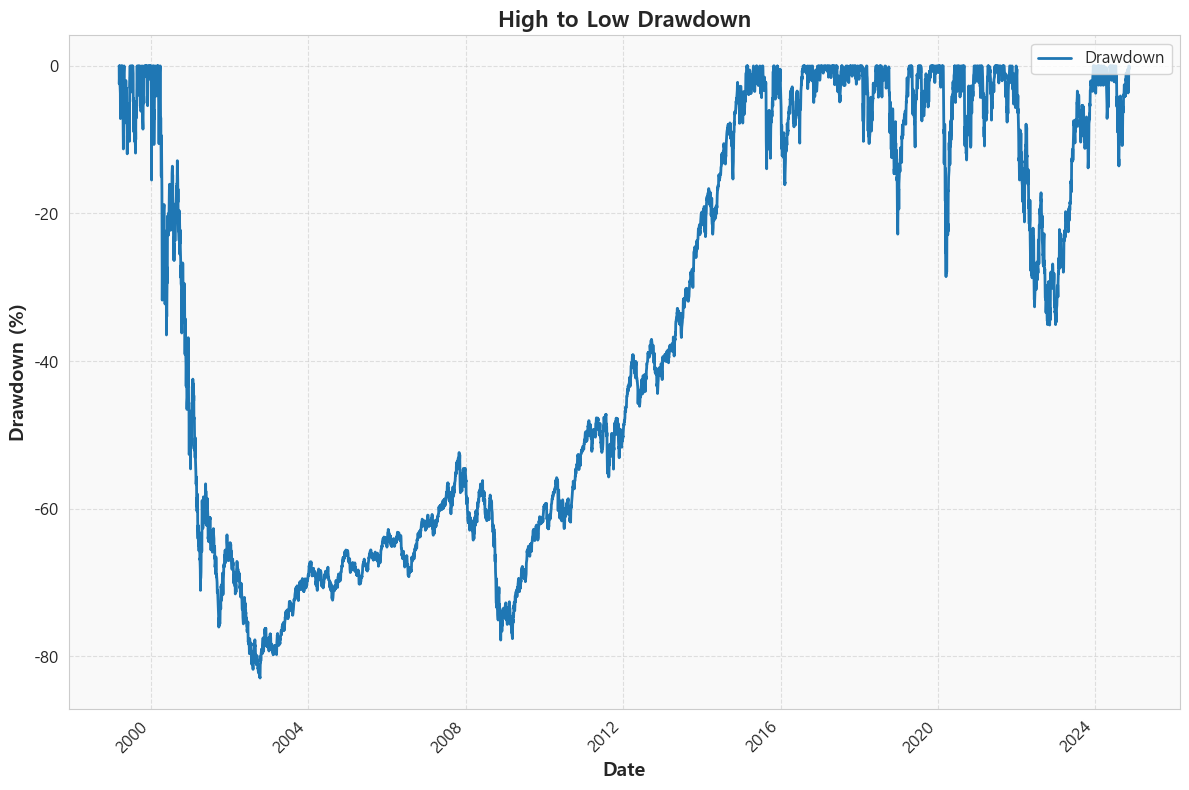

In [136]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot HRR
(HRR*100).plot(ax=ax, color='#1f77b4', linewidth=2)

# Add title and labels
ax.set_title('High to Low Drawdown', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Drawdown (%)', fontsize=14, fontweight='bold')

# Customize grid and background
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_facecolor('#f9f9f9')

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='x', rotation=45)

# Add legend
ax.legend(['Drawdown'], loc='upper right', fontsize=12)

# Show plot
plt.tight_layout()
plt.show()
# Find the point with the maximum drawdown


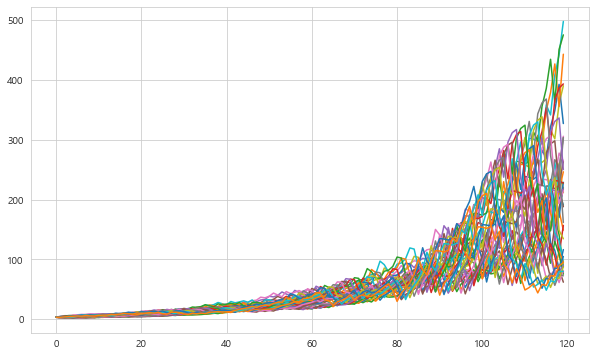

In [ ]:
(df_indi[X3]/(1300*1e4)).plot()
plt.legend().set_visible(False)